# Script 6: combine 2 spectra from different stars.

In this example, we combine two spectra of two different stars and, applying Doppler, obtain the combined spectrum for different radial speeds that will simulate different phases of the orbital period. A weighting factor will be introduced, so that we can vary the weight of each spectrum to the final combination.

In [1]:
from PyAstronomy import pyasl
from astropy.io import fits
from astropy.wcs import WCS
from scipy.constants import c
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline


Reading spectra module using WCS library. Spectrum to analize MUST be located in the same script folder.


In [2]:
def readSpec(filename):
  
    sp = fits.open(filename)
    sp.info()
    header = sp[0].header
    
    tf = sp[0].data
    tf = tf.flatten()    
    
    wcs = WCS(header)
    index = np.arange(header['NAXIS1'])

    wavelength = wcs.wcs_pix2world(index[:,np.newaxis], 0)
    wavelength = wavelength.flatten()  
    
    flux = sp[0].data
    sp.close()

    date_obs = header['DATE']

    return header, wavelength, flux, date_obs, tf

Module to calculate Doppler shift. The units of c are m / s. The NumPy interp function is used to interpolate the spectrum shifted by Doppler effect. Remember that spectrum [0] is the header, spectrum [1] is the wavelength, spectrum [2] is the flow, and spectrum [3] is the date of the original file. The function returns the new interpolated flux, while new wavelength is not used.

In [3]:
def dopplerShift(spectrum, speed):
   
    doppler_factor = np.sqrt((1 + speed/c)/(1 - speed/c))
    print ("Doppler factor:" + str(doppler_factor))
    
    new_wavelength = spectrum[1] * doppler_factor
    new_flux = np.interp(new_wavelength, spectrum[1], spectrum[2])
    
    return new_flux, doppler_factor

Function to combine spectra by an arithmetic weighted mean.

In [4]:
def combineSpectrum(flux_first_spec, flux_second_spec, weight_spectrum):
    
    combined_flux = flux_first_spec*weight_spectrum + flux_second_spec*(1-weight_spectrum)
    
    return combined_flux    

Function used to save spectra. Some fits headers are modified.


In [5]:
def saveSpectrum(filename, header, wavelength, flux, date_obs):
    
    header['CRVAL1'] = wavelength[0]
    header['DATE'] = date_obs
    hdu = fits.PrimaryHDU(flux, header)
    hdu.writeto(filename, overwrite=True)  
   

Function to plot spectra. We can change the size modifying the 'figsize' value.


In [6]:
def plotSpectrum(wavelength, flux):

    fig= plt.figure(figsize=(15,5))
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    axes.plot(wavelength, flux)
    plt.xlabel('wavelength')
    plt.ylabel('flux')
    plt.show()

### Core script.

Main variables and call to all the functions.

When entering Doppler shifts, remember that a positive value means a red shift. So the sign is changed to the primitive variable "speed" and multiplied by 1000 (km / s -> m / s).

The script asks for a value between 0 and 1 in order to fix the contribution of B spectrum (secondary star) in the combined spectra. Also, you can choose the Doppler shifts to generate the combined spectra.

Enter first spectrum to combine:ref25000_rw_100
Enter second spectrum to combine:ref25000_rw_100
Filename: ref25000_rw_100.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (109998,)   float64   
[3900.   3900.01 3900.02 ... 4999.95 4999.96 4999.97] [0.96575625 0.96578941 0.96582287 ... 0.99992368 0.99992345 0.99992323]
Filename: ref25000_rw_100.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      34   (109998,)   float64   
[3900.   3900.01 3900.02 ... 4999.95 4999.96 4999.97] [0.96575625 0.96578941 0.96582287 ... 0.99992368 0.99992345 0.99992323]
Spectrum of ref25000_rw_100


Changed DATE-OBS from '01/01/00' to '1900-01-01''. [astropy.wcs.wcs]


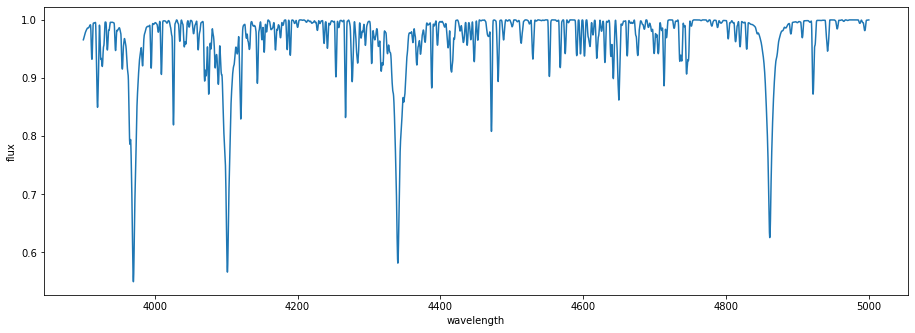

Spectrum of ref25000_rw_100


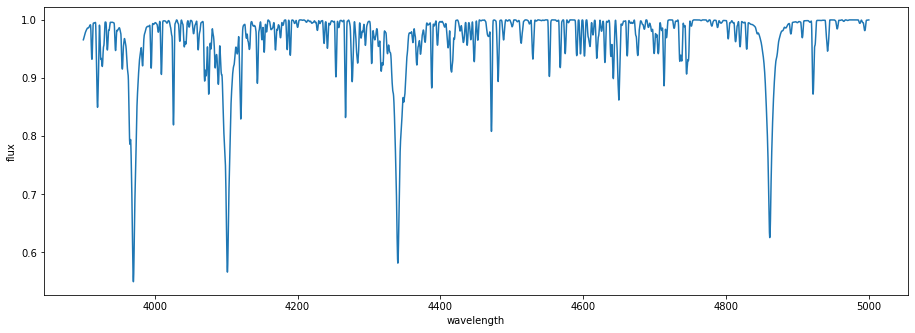

Weight first spectrum (0.0-1.0):0.2
Doppler shift increment (km/s):100

Generating combined spectra
Doppler shift: 0km/s
Doppler factor:1.0
Doppler factor:1.0


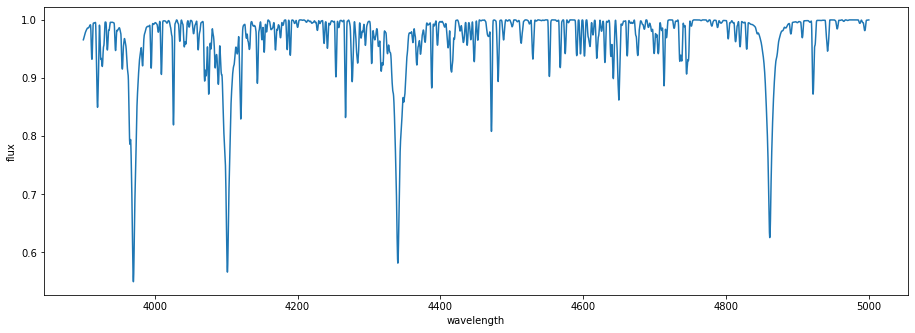

Doppler shift: 100km/s
Doppler factor:1.0003336197462627
Doppler factor:0.9996664915187522


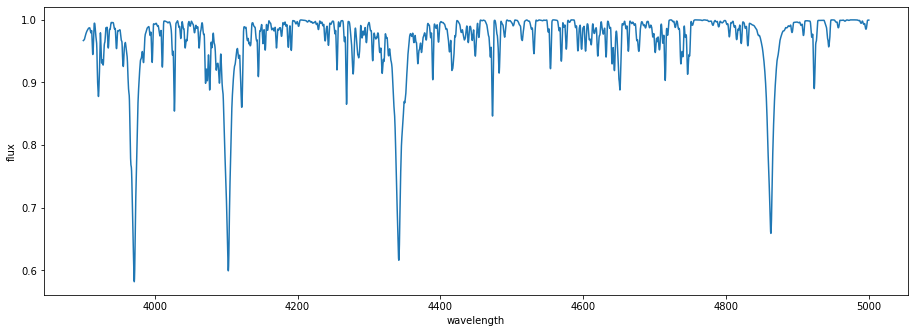

Doppler shift: 200km/s
Doppler factor:1.0006673508689379
Doppler factor:0.9993330941912332


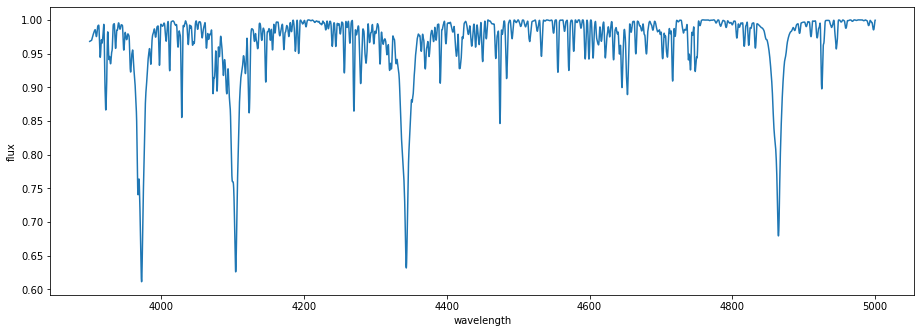

Doppler shift: 300km/s
Doppler factor:1.0010011934795353
Doppler factor:0.9989998079062673


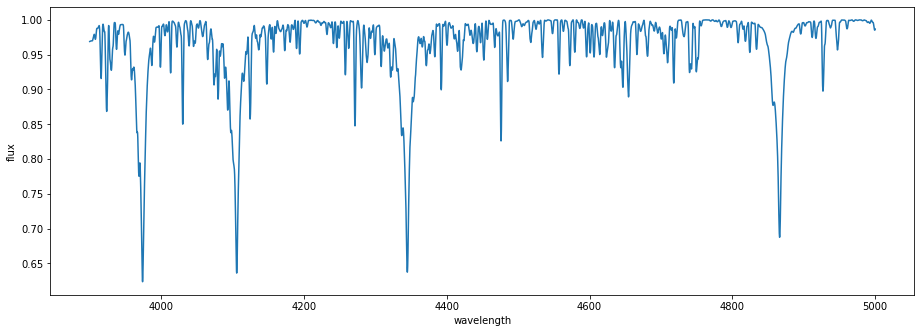

Doppler shift: 400km/s
Doppler factor:1.0013351476896757
Doppler factor:0.9986666325527908


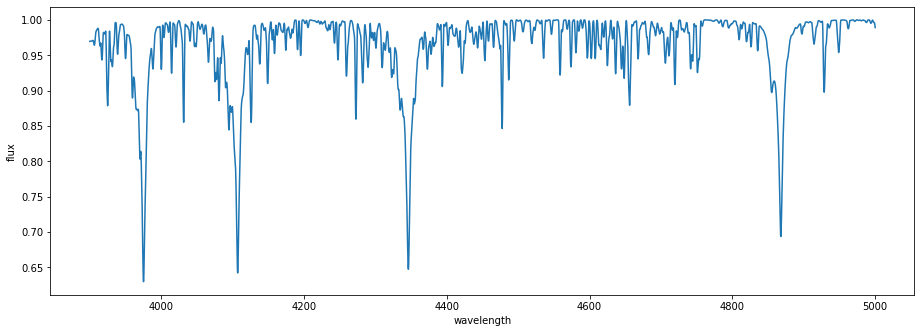

[1.0, 1.0003336197462627, 1.0006673508689379, 1.0010011934795353, 1.0013351476896757]
[1.0, 0.9996664915187522, 0.9993330941912332, 0.9989998079062673, 0.9986666325527908]
End


In [7]:
name_spectrum1 = input ("Enter first spectrum to combine:")
name_spectrum1f = name_spectrum1 + ".fits"

name_spectrum2 = input ("Enter second spectrum to combine:")
name_spectrum2f = name_spectrum2 + ".fits"

#Reading spectra
allData1 = readSpec(name_spectrum1f)
header1, wavelength1, flux1, date_obs1, tf1 = allData1
print(wavelength1, flux1)

allData2 = readSpec(name_spectrum2f)
header2, wavelength2, flux2, date_obs2, tf2 = allData2
print(wavelength2, flux2)

#Plotting spectra
print("Spectrum of " + name_spectrum1)
plotSpectrum(wavelength1, flux1)

print("Spectrum of " + name_spectrum2)
plotSpectrum(wavelength2, flux2)

#Enter weight of each spectrum
weight_spectrum = float(input("Weight second spectrum (0.0-1.0):"))

#Aplying Doppler shift
speed = -int(input("Doppler shift increment (km/s):"))
print("")
print("Generating combined spectra")

#Generate and save spectra
doppler_R = []
doppler_V = []
for i in range (0, 451, abs(speed)):
    print("Doppler shift: " + str(i) + "km/s")
    new_flux_spectrum1, doppler_1 = dopplerShift(allData1, i*1000)
    new_flux_spectrum2, doppler_2 = dopplerShift(allData2, -i*1000)
    combined_flux = combineSpectrum(new_flux_spectrum1, new_flux_spectrum2, weight_spectrum)
    
    plotSpectrum(wavelength1, combined_flux)
    
    filename = "Combined_" +name_spectrum1 + "_" + name_spectrum2 + "_shift_" + str(i) + ".fits"
    saveSpectrum(filename, header1, wavelength1, combined_flux, date_obs1)
    
    doppler_R.append(doppler_1)
    doppler_V.append(doppler_2)
    
print(doppler_R)
print(doppler_V)    
    
print("End")
